In [2]:
import glob
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

In [2]:
SEED = 8455

In [3]:
sns.set_style('darkgrid')

In [4]:
cols_to_skip = ['raw_text']

In [66]:
df_html_data = pd.concat([pd.read_csv(csv, lineterminator='\n', usecols=lambda x: x not in cols_to_skip)
               for csv in glob.glob('data/csv/*.csv')], ignore_index=True)
df_file_labels = pd.read_csv('data/html_targets.csv')
df = df_html_data.merge(df_file_labels, left_on='filename', right_on='file')
df = df.drop(['file', 'filename'], axis=1)

In [69]:
df.head()

,language,num_headers,num_paragraphs,num_tags,num_links,num_images,num_tables,num_lists,num_forms,num_inputs,...,num_embeds,num_lines,num_words,num_italic_words,num_bold_words,num_characters,num_unique_words,num_unique_characters,num_digits,sponsored
0,en,21,22,882,193,65,0,20,6,10,...,0,1980,1211,1,2,16288,668,80,267,0
1,NaN,5,17,572,151,76,0,4,1,1,...,0,1211,2036,17,2,17094,1125,78,117,0
2,NaN,6,3,531,169,32,0,5,1,2,...,0,1190,747,6,0,9668,403,72,30,0
3,NaN,145,6,2840,674,34,0,26,2,4,...,0,6594,6382,0,2,87962,2008,79,1240,0
4,NaN,16,19,433,87,6,0,17,2,10,...,0,977,539,0,41,6578,291,64,42,0


In [68]:
df.describe()

,num_headers,num_paragraphs,num_tags,num_links,num_images,num_tables,num_lists,num_forms,num_inputs,num_buttons,...,num_embeds,num_lines,num_words,num_italic_words,num_bold_words,num_characters,num_unique_words,num_unique_characters,num_digits,sponsored
count,337024.000000,337024.000000,337024.000000,337024.00000,337024.000000,337024.000000,337024.000000,337024.000000,337024.000000,337024.000000,...,337024.000000,337024.000000,3.370240e+05,337024.000000,337024.000000,3.370240e+05,337024.000000,337024.000000,337024.000000,337024.000000
mean,15.117422,29.244612,697.546198,144.11325,29.466815,1.345064,14.948155,2.277393,10.181800,1.672611,...,0.034030,1649.578327,4.344077e+03,7.302210,9.020832,2.984456e+04,570.453205,70.436984,388.203116,0.096963
std,26.249504,108.921037,1175.236909,325.99326,96.623238,13.146913,32.369360,7.288580,23.076891,9.672854,...,0.412587,2972.589774,2.417431e+04,37.006535,46.802491,1.226782e+05,722.457100,15.852156,2773.216815,0.295908
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,290.000000,48.00000,5.000000,0.000000,3.000000,1.000000,1.000000,0.000000,...,0.000000,686.000000,4.010000e+02,0.000000,0.000000,5.501000e+03,205.000000,68.000000,30.000000,0.000000
50%,9.000000,15.000000,528.000000,100.00000,17.000000,0.000000,9.000000,2.000000,5.000000,0.000000,...,0.000000,1185.000000,8.750000e+02,0.000000,1.000000,1.049200e+04,431.000000,74.000000,79.000000,0.000000
75%,18.000000,31.000000,834.000000,171.00000,35.000000,1.000000,18.000000,3.000000,12.000000,1.000000,...,0.000000,1899.250000,1.617000e+03,4.000000,7.000000,1.881100e+04,707.000000,79.000000,211.000000,0.000000
max,2924.000000,36328.000000,296536.000000,113886.00000,37065.000000,4551.000000,2721.000000,494.000000,2030.000000,1957.000000,...,74.000000,667203.000000,3.680651e+06,10621.000000,9934.000000,1.660190e+07,100023.000000,256.000000,822549.000000,1.000000


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337024 entries, 0 to 337023
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   language               209170 non-null  object
 1   num_headers            337024 non-null  int64 
 2   num_paragraphs         337024 non-null  int64 
 3   num_tags               337024 non-null  int64 
 4   num_links              337024 non-null  int64 
 5   num_images             337024 non-null  int64 
 6   num_tables             337024 non-null  int64 
 7   num_lists              337024 non-null  int64 
 8   num_forms              337024 non-null  int64 
 9   num_inputs             337024 non-null  int64 
 10  num_buttons            337024 non-null  int64 
 11  num_scripts            337024 non-null  int64 
 12  num_styles             337024 non-null  int64 
 13  num_iframes            337024 non-null  int64 
 14  num_embeds             337024 non-null  int64 
 15  

#### We are dealing with an imbalanced dataset with a ~10/90 split

<AxesSubplot:xlabel='sponsored', ylabel='count'>

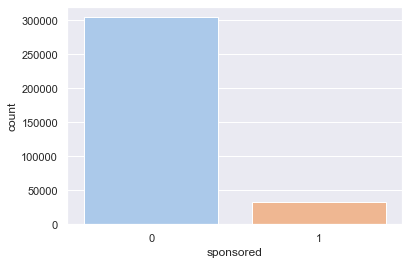

In [47]:
sns.countplot(data=df_file_labels, x='sponsored')

#### First model

In [82]:
X = df[df.columns.difference(['sponsored', 'language'])]
y = df['sponsored']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [84]:
clf = DecisionTreeClassifier(random_state=SEED, criterion="entropy",
                             min_samples_split=10, min_samples_leaf=10, max_depth=10, max_leaf_nodes=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [86]:
# predicts all yes
confusion_matrix(y_test, y_pred)

array([[60946,     0],
       [ 6459,     0]])

In [94]:
clf_rf = RandomForestClassifier(
    n_estimators=100, max_depth=None, min_samples_split=2, random_state=SEED)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=8455)

In [95]:
y_pred_rf = clf_rf.predict(X_test)

In [96]:
# predicts all yes
confusion_matrix(y_test, y_pred_rf)

array([[60762,   184],
       [ 3822,  2637]])

In [99]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     60946
           1       0.93      0.41      0.57      6459

    accuracy                           0.94     67405
   macro avg       0.94      0.70      0.77     67405
weighted avg       0.94      0.94      0.93     67405



In [102]:
sorted(zip(X_train.columns, clf_rf.feature_importances_), key=lambda x: x[1] * -1)

[('num_scripts', 0.06774712700430925),
 ('num_links', 0.0655084267921183),
 ('num_lines', 0.06392637421743785),
 ('num_tags', 0.06203448371099428),
 ('num_digits', 0.06160677199711946),
 ('num_characters', 0.059580442804187186),
 ('num_inputs', 0.057995553782739885),
 ('num_images', 0.0566566579501215),
 ('num_words', 0.05377045704540885),
 ('num_headers', 0.05311292065422105),
 ('num_unique_words', 0.05246332356591352),
 ('num_lists', 0.05114785444858657),
 ('num_paragraphs', 0.04806513683409027),
 ('num_unique_characters', 0.04102698557376588),
 ('num_styles', 0.03675722192670543),
 ('num_buttons', 0.036070415766639066),
 ('num_italic_words', 0.03447154967722659),
 ('num_bold_words', 0.03228591386918294),
 ('num_forms', 0.0310366630134473),
 ('num_iframes', 0.021098313358135095),
 ('num_tables', 0.01234029866676555),
 ('num_embeds', 0.0012971073408842286)]